# Wavelet toy-model

This tutorial shows how to use the the WaveletSource instead of pixelated sources. For a more in-depth introduction to *scarlet*, read the [Core Concepts](1-concepts.ipynb) or the [API Documentation](api/index.rst).

In [24]:
# Import Packages and setup
import numpy as np
import scarlet
import scarlet.display

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a superior colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gist_stern', interpolation='none')

## Load and Display Data

We load an example data set (here an image cube with 5 bands) *and* a detection catalog.
If such a catalog is not available packages like [SEP](http://sep.readthedocs.io/) and [photutils](https://photutils.readthedocs.io/en/stable/) will happily generate one, but for this example we use part of the detection catalog generated by the [LSST DM stack](https://github.com/lsst). 

In [25]:
# Load the sample images
data = np.load("../../LSST_Project/scarlet/data/hsc_cosmos_35.npz")
images = data["images"]
filters = data["filters"]
catalog = data["catalog"]
weights = 1/data["variance"]
psfs = scarlet.PSF(data["psfs"])

This shows how the wavelet transform and inverse transform works in scarlet. As a check we make sure that the transform and its inverse lead to the original image.

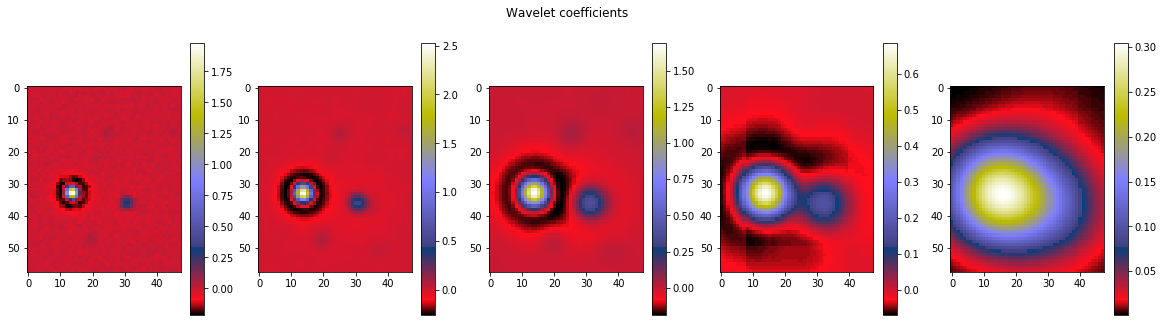

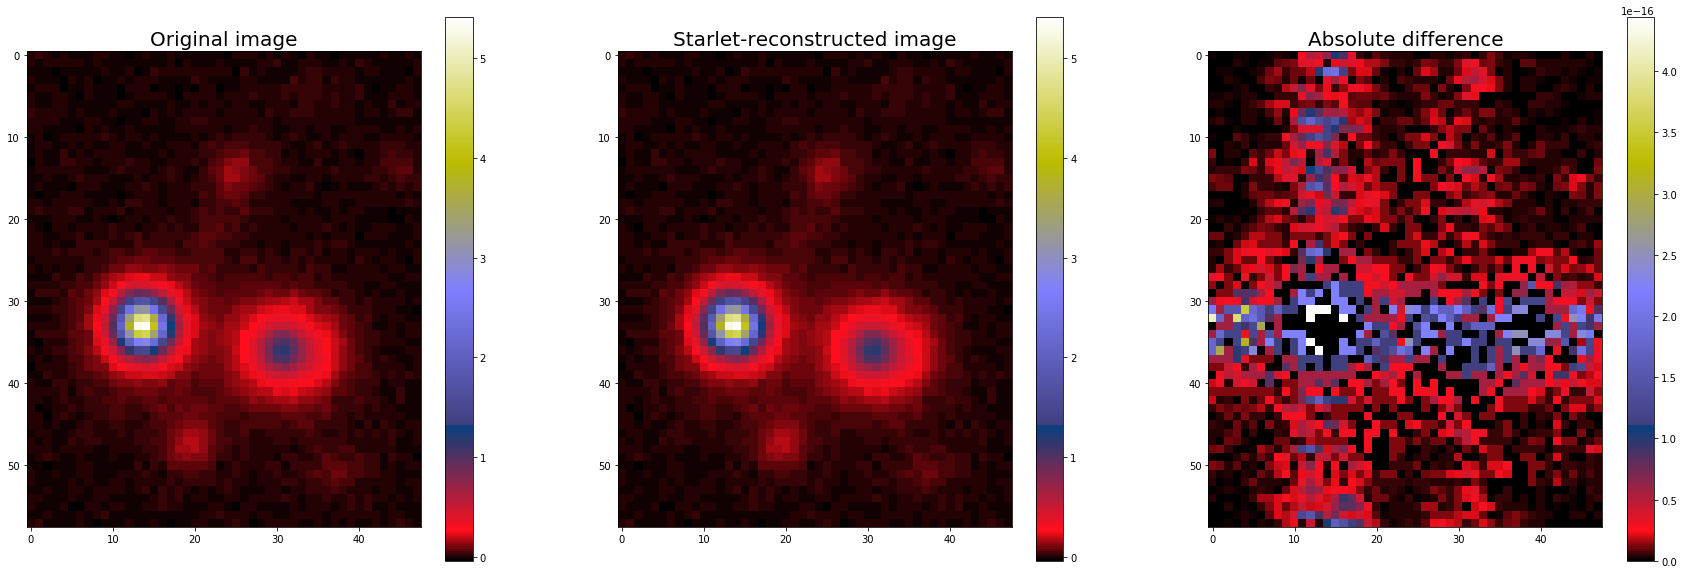

In [29]:
#Declare a starlet object (and performs the transform)
Sw = scarlet.Starlet(images, direct = True)
#This is the starlet transform as an array
w = Sw.starlet
#The inverse starlet transform of w
iw = scarlet.Starlet.from_starlet(w, images.shape).image

#The wavelet transform of the first slice of images in pictures:
plt.figure(figsize = (20,5))
plt.suptitle('Wavelet coefficients')
lvl = w.shape[1]
for i in range(lvl):
    plt.subplot(1,lvl,i+1)
    plt.imshow(w[0,i])
    plt.colorbar()
plt.show()

#Making sure we recover the original image:
plt.figure(figsize = (30,10))
plt.subplot(131)
plt.title('Original image', fontsize = 20)
plt.imshow(images[0])
plt.colorbar()
plt.subplot(132)
plt.title('Starlet-reconstructed image', fontsize = 20)
plt.imshow(iw[0])
plt.colorbar()
plt.subplot(133)
plt.title('Absolute difference', fontsize = 20)
plt.imshow((np.abs(iw[0]-images[0])))
plt.colorbar()
plt.show()

### Display Image Cube
This is an example of how to display an RGB image from an image cube of multiband data. In this case the image uses a $sinh^{-1}$ function to normalize the flux in each filter consistently to create an RGB image.

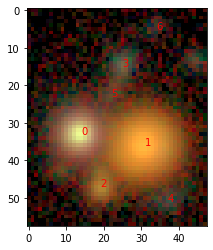

In [30]:
from scarlet.display import AsinhMapping

stretch = 0.2
Q = 10
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
plt.imshow(img_rgb)

# Mark all of the sources from the detection cataog
for k, src in enumerate(catalog):
    plt.text(src["x"], src["y"], str(k), color="red")

## Define Model Frame and Observation

A `Frame` in *scarlet* is a description of the hyperspectral cube of the model or the observations. Think of it as the metadata, what aspects of the sky are described here. At the least, a `Frame` holds the `shape` of the cube, for which we use the convention `(C, Ny, Nx)` for the number of elements in 3 dimensions: `C` for the number of bands/channels and `Ny, Nx` for the number of pixels at every channel.

An `Observation` combines a `Frame` with several data units, similar to header-data arrangement in FITS files. In addition to the actual science image cube, you can and often must provide weights for all elements in the data cube, an image cube of the PSF model (one image for all or one for each channel), an `astropy.WCS` structure to translate from pixel to sky coordinates, and labels for all channels. The reason for specifying them is to enable the code to internally map from the model frame, in which you seek to fit a model, to the observed data frame.

In this example, we assume that bands and pixel locations are identical between the model and the observation. Because we have ground-based images with different PSFs in each band, we need to provide a reference PSF for the model. We simply choose a minimal Gaussian PSF that is barely well sampled as our reference kernel:

In [31]:
from functools import partial
model_psf = scarlet.PSF(partial(scarlet.psf.gaussian, sigma=.8), shape=(None, 8, 8))

With this we can fully specify the `Frame` and `Observation`:

In [32]:
model_frame = scarlet.Frame(
    images.shape,
    psfs=model_psf,
    channels=filters)

observation = scarlet.Observation(
    images, 
    psfs=psfs, 
    weights=weights, 
    channels=filters).match(model_frame)

The last command calls the `match` method to compute e.g. PSF difference kernel and filter transformations.

We generally recommend this pattern:
1. define model frame
2. construct observation
3. match it to the model frame

Steps 2 and 3 are combined above using a fluent pattern.

## Initialize sources

You now need to define sources that are going to be fit. The full model, which we will call `Blend`, is a collection of those sources. We provide several pre-built source types:

* `PointSource` fits centers and per-band amplitude using the observed PSF model.
* `WaveletSource` fits per-band amplitude and a non-parametric morphology in wavelet space and constrained in its L0 norm.


In [33]:
sources = []
for k,src in enumerate(catalog):
    if k == 0:
        new_source = scarlet.PointSource(model_frame, (src['y'], src['x']), observation)
    else:
        new_source = scarlet.WaveletSource(model_frame, (src['y'], src['x']), observation, thresh=5)
    sources.append(new_source)

## Create and Fit Model
The `Blend` class represents the sources as a tree and has the machinery to fit all of the sources to the given images. In this example the code is set to run for a maximum of 200 iterations, but will end early if the likelihood and all of the constraints converge.

CPU times: user 10.8 s, sys: 67.5 ms, total: 10.9 s
Wall time: 10.9 s
scarlet ran for 174 iterations to logL = 28487.161606648646


Text(0, 0.5, 'log-Likelihood')

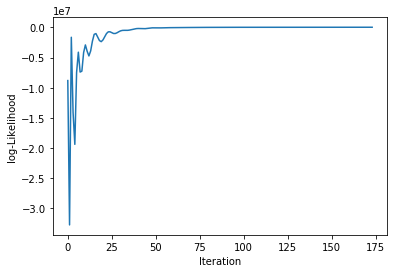

In [34]:
blend = scarlet.Blend(sources, observation)
%time blend.fit(200)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend.loss), -blend.loss[-1]))
plt.plot(-np.array(blend.loss))
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')

## Interact with Results

### View Full Scene

We could use `scarlet.display.show_scene` to render to entire scene, but it's instructive to see how the model and the comparison to observations is performed.
First we load the model for the entire scene, render it in the observation frame, and compute its residuals. We then show model and data with the same $sinh^{-1}$ stretch and the residuals with a linear stretch.

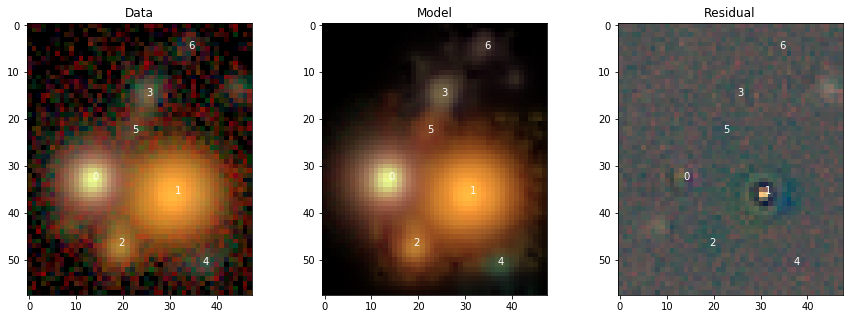

In [35]:
# Load the model and calculate the residual
model = blend.get_model()
model_ = observation.render(model)
residual = images-model_

# Create RGB images
model_rgb = scarlet.display.img_to_rgb(model_, norm=norm)
residual_rgb = scarlet.display.img_to_rgb(residual)

# Show the data, model, and residual
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
ax[0].imshow(img_rgb)
ax[0].set_title("Data")
ax[1].imshow(model_rgb)
ax[1].set_title("Model")
ax[2].imshow(residual_rgb)
ax[2].set_title("Residual")

for k,component in enumerate(blend):
    y,x = component.center
    ax[0].text(x, y, k, color="w")
    ax[1].text(x, y, k, color="w")
    ax[2].text(x, y, k, color="w")
plt.show()

### View Source Models

We will now inspect the model for each source, in its original frame and in its observed frame by leveraging the `show_sources` method:

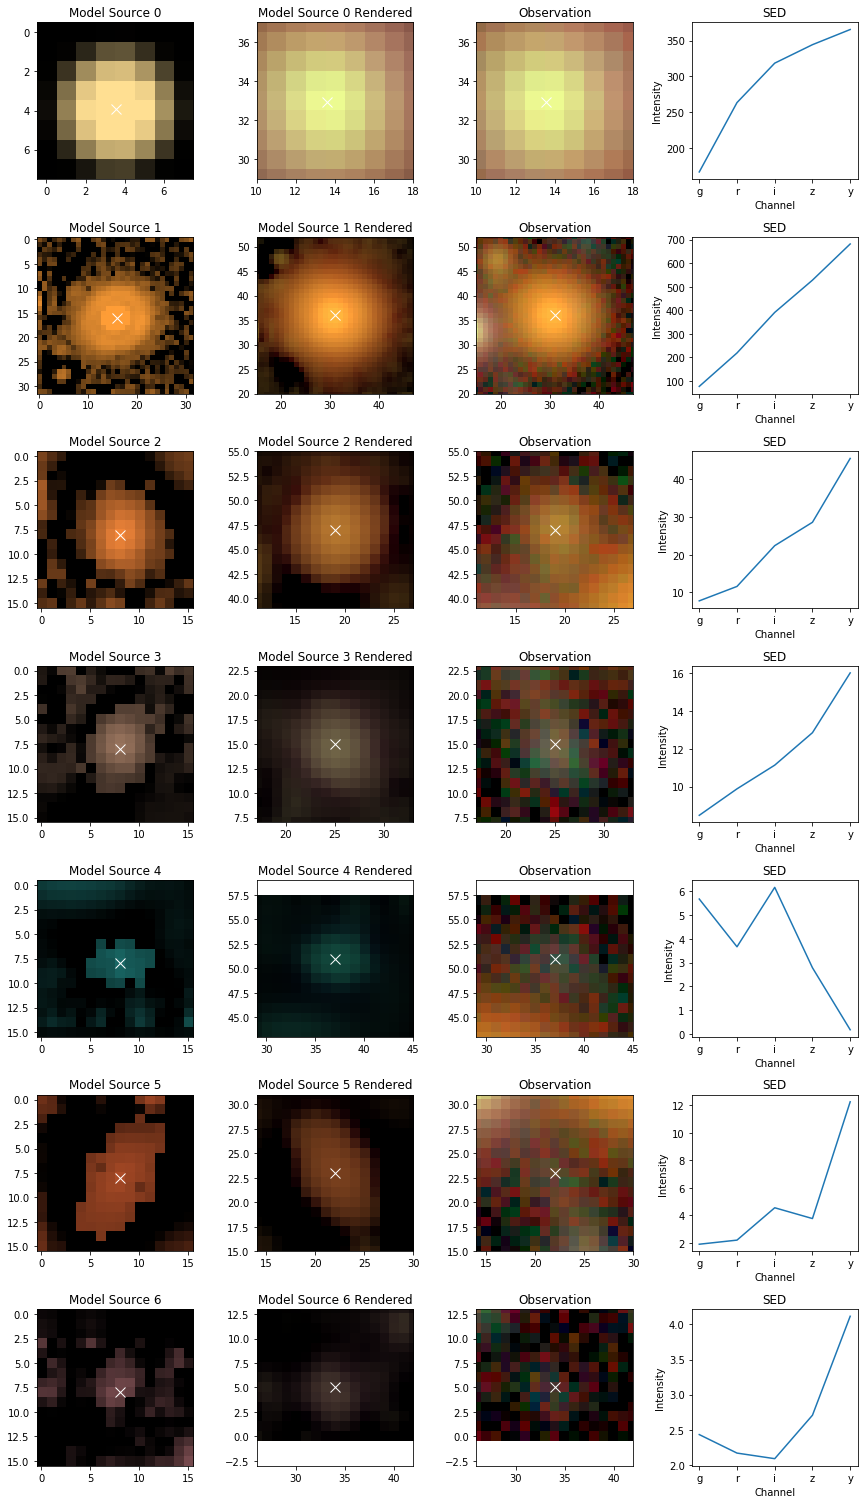

In [36]:
scarlet.display.show_sources(sources, 
                             norm=norm, 
                             observation=observation,
                             show_rendered=True, 
                             show_observed=True)

We can see that each source "lives" in a smaller box and is then placed into the larger scene. The model of object 0 assumes the simple Gaussian shape of the model PSF, which is the internal representation of a point source. Source 1 uses the freedom of the 2-compoent model to represent a slightly redder core; the difference in SEDs is clearly noticeable.

### Measure Fluxes

The color information in these plots stems from the per-band amplitude, which could be obtained as `source.sed`. However, it is more useful to compute per-band fluxes, which integrate over the morphology. The source SED plots above have done exactly that. The convention of these fluxes is given by the units and ordering of the original data cube. In the case of multi-component sources, the fluxes of all components are combined.

In [37]:
print ("----------------- {}".format(filters))
for k, src in enumerate(sources):
    print ("Source {}, Fluxes: {}".format(k, scarlet.measure.flux(src)))

----------------- ['g' 'r' 'i' 'z' 'y']
Source 0, Fluxes: [166.49078834 263.37090398 318.44637403 344.23579271 365.41147737]
Source 1, Fluxes: [ 76.74112678 218.72130764 390.96186471 527.88109785 681.5059912 ]
Source 2, Fluxes: [ 7.75273726 11.58169892 22.4034031  28.60738138 45.55679845]
Source 3, Fluxes: [ 8.47516454  9.87710623 11.13182834 12.85105884 16.01885556]
Source 4, Fluxes: [5.67680019 3.66832631 6.16832388 2.78671214 0.1776083 ]
Source 5, Fluxes: [ 1.90048382  2.198814    4.55190702  3.76729395 12.25752862]
Source 6, Fluxes: [2.43287541 2.16984382 2.09026056 2.70799557 4.11523008]


Other measurements (e.g. `centroid`) are also implemented. The measurement approach is also easily extendable. The source models are generated in the model frame (which is the best-fit representation of the full hyperspectral `Frame`), from which any measurement can directly be made without having to deal with noise, PSF convolution, overlapping sources, etc. 

### Save and Re-Use Model

To preserve the model for posterity, individual sources or lists of sources can be serialized with the `pickle` library:

In [38]:
import pickle
fp = open("hsc_cosmos_35.sca", "wb")
pickle.dump(sources, fp)
fp.close()

The pickled file can be reopened in the same way. Every source can be utilized as before.

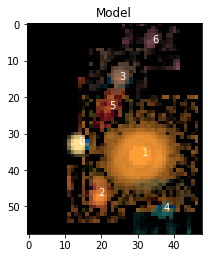

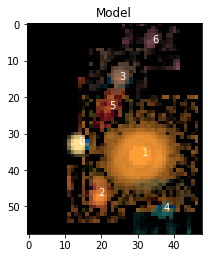

In [39]:
fp = open("hsc_cosmos_35.sca", "rb")
sources_ = pickle.load(fp)
fp.close()

scarlet.display.show_scene(sources_, norm=norm)

However, if we want to refit some data with this model, we have to recreate a `Blend` instance.

We will now add two more sources to account for the largest residuals we have seen above. As we don't know their location accurately, we allow the fitter to shift/recenter the sources.

In [40]:
# first freeze existing sources: they are not updated during fit
for src in sources_:
    src.freeze()

# add two sources at their approximate locations
yx = (14., 44.)
new_source = scarlet.ExtendedSource(src.frame, yx, observation, shifting=True, symmetric=False, monotonic=True, thresh=5)
sources_.append(new_source)
yx = (43., 12.)
new_source = scarlet.ExtendedSource(src.frame, yx, observation, shifting=True, symmetric=False, monotonic=True, thresh=5)
sources_.append(new_source)

# generate a new Blend instance
blend_ = scarlet.Blend(sources_, observation)
# fit only new sources
blend_.fit(200)

# joint fit: fit all sources
blend_.unfreeze()
blend_.fit(200)

# show convergence of logL
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend_.loss), -blend_.loss[-1]))
plt.plot(-np.array(blend.loss), 'k--', label='7 sources')
plt.plot(-np.array(blend_.loss), label='7+2 sources')
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')
plt.legend()

AttributeError: 'PointSource' object has no attribute 'freeze'

We can see that logL is slightly higher than before. To be clear, **this is *not* the smartest way to refit a model**. We did some fine-tuning with two new sources (for about 10 iterations), and then fit all of them again from scratch. That's where the wild oscillations come from and why it takes so long to converge. Anyway, let's have a look at the new model:

In [ ]:
scarlet.display.show_scene(sources_, 
                           norm=norm, 
                           observation=observation, 
                           show_rendered=True, 
                           show_observed=True, 
                           show_residual=True)

We can see the two new sources 7 and 8, and that most of the features are very similar to before. As expected, the residuals have visibly improved and are now dominated by a Yin-Yang-shaped orange-blue pattern in the center of source 1, which we already fit with 2 components. Maybe we should try with 3 ...

In [ ]:
# minimal regression testing (hidden in sphinx)
np.testing.assert_almost_equal(-blend_.loss[-1], 30945.869017078174, decimal=3)